## Crank-Nicolson scheme

Implicit method used with parabolic PDEs

Main idea: Take the average between the solutions at $t^n$ and $t^{n+1}$ in evaluation of the spatial derivative.  This is so that the time derivative will be discretized with a centered scheme, thus giving it second order accuracy.

1D Heat Equation:

$$\frac{\partial T}{\partial t} = \alpha \frac{\partial ^2 T}{\partial x^2}$$

From this, Crank-Nicolson scheme leads to:

$$\frac{T_i ^{n+1} - T_i ^n}{\Delta t} = \alpha \circ \frac{1}{2} \left( \frac{T_{i+1} ^{n+1} - 2T_i ^{n+1} + T_{i-1} ^{n+1}}{\Delta x^2} + \frac{T_{i+1} ^n - 2T_i ^n + T_{i-1} ^n}{\Delta x^2} \right)$$

n and n+1 both appear on the right hand side.  Gotta rearrange the equation.

Everything we don't know is on the left and everything we know is on the right.

$$-T_{i-1} ^{n+1} + 2 \left( \frac{\Delta x^2}{\alpha \Delta t} + 1 \right) T_i ^{n+1} - T_{i+1} ^{n+1} = T_{i-1} ^n + 2 \left( \frac{\Delta x^2}{\alpha \Delta t} - 1 \right) T_i ^n + T_{i+1} ^n$$

LHS looks like the matrix from notebook 2.  Not much change for the boundary conditions either.

### The linear system

Need to solve a linear system on every time step of the form:

$$[A][T_{int} ^{n+1}] = [b] + [b]_{b.c.}$$

Need a function that will create the coefficient matrix and the RHS for the heat conduction problem from notebook 2, with a Dirichlet BC at $x = 0$ and zero-flux boundary $(q = 0)$ at $x = L$

In [1]:
import numpy
from scipy.linalg import solve

In [2]:
def generateMatrix(N, sigma):
    """Computes the matrix for the diffusion equation with Crack-Nicolson
       Dirichlet condition at i = 0, Neumann at i = -1
       
    Parameters:
    ----------
    N : int
        Number of discretization points
    sigma : float
        alpha * dt / dx ^2
        
    Returns:
    -------
    A : 2D numpy array of float
        Matrix for diffusion equation
    """
    
    #Setup the diagonal
    d = 2 * numpy.diag(numpy.ones(N - 2) * (1 + 1. / sigma))
    
    #Consider Neumann BC
    d[-1, -1] = 1 + 2. / sigma
    
    #Setup upper diagonal
    ud = numpy.diag(numpy.ones(N - 3) * -1, 1)
    
    #Setup lower diagonal
    ld = numpy.diag(numpy.ones(N - 3) * -1, -1)
    
    A = d + ud + ld
    
    return A

In [3]:
def generateRHS(T, sigma):
    """Computes RHS of linear system for diffusion equation with backward Euler
    
    Parameters:
    ----------
    T : array of float
        Temperature at current time-step
    sigma : float
        alpha * dt / dx ^ 2
        
    Returns:
    -------
    b : array of float
        RHS of diffusion equation with backward Euler
    """
    
    b = T[1: - 1] * 2 * (1. / sigma - 1) + T[:-2] + T[2:]
    
    #Dirichlet BC
    b[0] += T[0]
    
    return b

In [4]:
def CrankNicolson(T, A, nt, sigma):
    """Advances diffusion equation in time with Crank-Nicolson
    
    Parameters:
    ----------
    T : array of float
        initial temperature profile
    A : 2D array of float
        Matrix with discretized diffusion equation
    nt : int
        Number of time-steps
    sigma : float
        alpha * dt / dx ^ 2
        
    Returns:
    -------
    T : array of floats
        Temperature profile after nt time-steps
    """
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(Tn, sigma)
        #Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior
        #Neumann BC (Dirichlet is auto)
        T[-1] = T[-2]
        
    return T

In [5]:
L = 1
nx = 21
alpha = 1.22e-3

dx = L / (nx - 1)

Ti = numpy.zeros(nx)
Ti[0] = 100

sigma = 0.5
dt = sigma * dx * dx / alpha
nt = 10

A = generateMatrix(nx, sigma)

In [6]:
print(A)

[[ 6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [-1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0

In [7]:
T = CrankNicolson(Ti.copy(), A, nt, sigma)

In [8]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

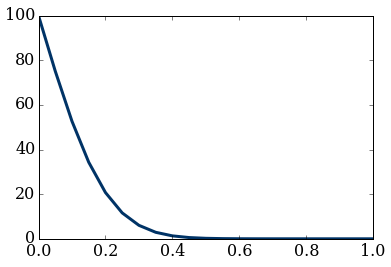

In [9]:
x = numpy.linspace(0, L, nx)

pyplot.plot(x, T, color = '#003366', ls = '-', lw = 3);

Analytical solution of T

$$T(x, t) = 100 - \sum_{n=1}^{\infty} \frac{400}{(2n - 1)\pi} sin \left(\frac{(2n - 1) \pi}{2L} x \right) exp \left[ -\alpha \left( \frac{(2n-1) \pi}{2L} \right) ^2 (2t) \right]$$

In [10]:
from math import pi
def T_analytical(x, t, n_max, alpha, L):
    """Compute the exact solution for 1D diffusion with T = 100 at x = 0 and dT/dx = 0 at x = L
    
    Parameters:
    ----------
    x : array of float
        Spatial position
    t : float
        Evaluation time
    n_max : int
        Number of terms to evaluate expression
    alpha : float
        diffusion coefficient
    L : float
        Size of rod
    
    Returns:
    -------
    T : array of float
        Temperature at each location x
    """
    
    T = 100
    for n in range(1, n_max + 1):
        k = (2 * n - 1) * pi / (2 * L)
        
        summation = 400 / ((2 * n - 1) * pi) * numpy.sin(k * x) * numpy.exp(-alpha * k * k * t)
        T -= summation
    
    return T

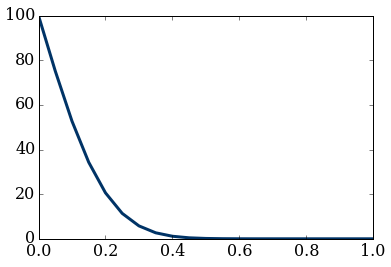

In [11]:
T_exact = T_analytical(x, dt * nt, 100, alpha, L)

pyplot.plot(x, T_exact, color = '#003366', ls = '-', lw = 3);

In [12]:
T1 = T_analytical(x, .2, 100, alpha, L)
T2 = T_analytical(x, .2, 200, alpha, L)

numpy.sqrt(numpy.sum((T1-T2) ** 2) / numpy.sum(T2 ** 2))

6.9279171182600926e-13

### Time convergence

Second order accurate.  Gotta check.

Leave $\Delta x$ constant. Run code for diff values of $\Delta t$ and compare at $t = n_t \circ \Delta t = 10$ with the analytical expression.

Initial conditions: Very sharp gradient: sudden jump from 0 to 100 at the boundary.  To make sure it doesn't affect time convergence we need a very fine mesh and computations would be slow.  To avoid this we'll start from $t = 1$ instead of $t = 0$.

Need to compute $L_2$ norm of the error:

In [13]:
def L2_error(T, T_exact):
    """Computes L2 norm of error
    
    Parameters:
    ----------
    T : array of float
        array with numerical solution
    T_exact: array of float
        array with exact solution
    
    Returns:
    -------
    e : L2 norm of error
    """
    
    e = numpy.sqrt(numpy.sum((T - T_exact) ** 2) / numpy.sum(T_exact) ** 2)
    
    return e

In [19]:
#For fun compare Crank-Nicolson with implicit backward Euler scheme

def generateMatrix_btcs(N, sigma):
    """Computes the matrix for the diffusion equation with backward Euler
       Dirichlet condition at i = 0 and Neumann at i = - 1
    
    Parameters:
    ----------
    T : array of float
        Temperature at current time step
    sigma : float
        alpha * dt / dx ^ 2
        
    Returns:
    -------
    A : 2D numpy array of float
        Matrix for diffusion equation
    """
    
    #Set up diagonal
    d = numpy.diag(numpy.ones(N - 2) * (2 + 1. / sigma))
    
    #Neumann BC
    d[-1, -1] = 1 + 1. / sigma
    
    #Set up upper diag
    ud = numpy.diag(numpy.ones(N - 3) * -1, 1)
    
    #Set up lower diag
    ld = numpy.diag(numpy.ones(N - 3) * -1, -1)
    
    A = d + ud + ld
    
    return A

In [20]:
def generateRHS_btcs(T, sigma):
    """Computes RHS of linear system for diffusion equation with backwards Euler
    
    Parameters:
    ----------
    T : array of float
        Temperature at current time step
    sigma : float
        alpha * dt / dx ^2
        
    Returns:
    -------
    b : array of float
        RHS of diffusion euqation with backward Euler
    """
    
    b = numpy.zeros_like(T)
    
    b = T[1:-1] * 1. / sigma
    
    #Dirichlet BC
    b[0] += T[0]
    
    return b

In [21]:
def implicit_btcs(T, A, nt, sigma):
    """Advances diffusion equation in time with implicit central scheme
    
    Parameters:
    ----------
    T : array of float
        initial temperature profile
    A : 2D array of float
        Matrix with discretized diffusion equation
    nt : int
        Number of time steps
    sigma : float
        alpha * dt / dx ^ 2
    
    Returns:
    -------
    T : array of floats
        Temperature profile after nt time steps
    """
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS_btcs(Tn, sigma)
        
        #Use numpy.linalg.solve
        T_interior = solve(A, b)
        T[1: -1] = T_interior
        
        #Neumann BC (Dirichlet auto)
        T[-1] = T[-2]
        
    return T

In [22]:
nx = 1001
dx = L / (nx - 1)

dt_values = numpy.asarray([1.0, 0.5, 0.25, 0.125])
error = numpy.zeros(len(dt_values))
error_ftcs = numpy.zeros(len(dt_values))

t_final = 10
t_initial = 1

x = numpy.linspace(0, L, nx)

Ti = T_analytical(x, t_initial, 100, alpha, L)
T_exact = T_analytical(x, t_final, 100, alpha, L)

for i, dt in enumerate(dt_values):
    sigma = alpha * dt / dx ** 2
    
    nt = int((t_final - t_initial) / dt)
    
    A = generateMatrix(nx, sigma)
    
    A_btcs = generateMatrix_btcs(nx, sigma)
    
    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    
    error[i] = L2_error(T, T_exact)
    
    T = implicit_btcs(Ti.copy(), A_btcs, nt, sigma)
    
    error_ftcs[i] = L2_error(T, T_exact)

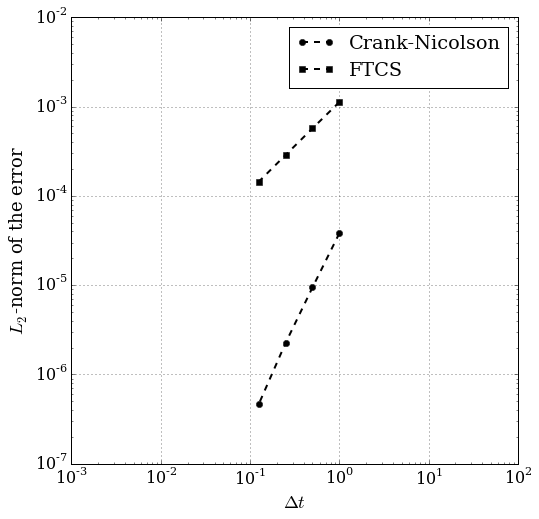

In [23]:
pyplot.figure(figsize = (8, 8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize = 18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize = 18)
pyplot.axis('equal')
pyplot.loglog(dt_values, error, color = 'k', ls = '--', lw = 2, marker = 'o')
pyplot.loglog(dt_values, error_ftcs, color = 'k', ls = '--', lw = 2, marker = 's')
pyplot.legend(['Crank-Nicolson', 'FTCS']);

In [24]:
error

array([  3.81125927e-05,   9.41813943e-06,   2.25089054e-06,
         4.63970974e-07])

Error drops four times when the time step is halved and is therefore second order in time.

Crank-Nicolson converges faster than backward Euler and is more accurate.

### Spatial convergence

To study spatial convergence the code will be run for meshes with 21, 41, 81, and 161 points and will be compared at the same non-dimentional time at $t = 20$

In [25]:
nx_values = numpy.asarray([11, 21, 41, 81, 161])

dt = 0.1
error = numpy.zeros(len(nx_values))

t_final = 20

x = numpy.linspace(0, L, nx)

for i, nx in enumerate(nx_values):
    
    dx = L / (nx - 1)
    
    x = numpy.linspace(0, L, nx)
    
    sigma = alpha * dt / dx ** 2
    
    nt = int(t_final / dt)
    
    A = generateMatrix(nx, sigma)
    
    Ti = numpy.zeros(nx)
    Ti[0] = 100
    
    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    
    T_exact = T_analytical(x, t_final, 100, alpha, L)
    
    error[i] = L2_error(T, T_exact)